In [1]:
#load libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
#read data 
df = pd.read_csv("raw\WA_Fn-UseC_-Telco-Customer-Churn.csv")

<>:2: SyntaxWarning: invalid escape sequence '\W'
<>:2: SyntaxWarning: invalid escape sequence '\W'
C:\Users\hanam\AppData\Local\Temp\ipykernel_20292\1355701220.py:2: SyntaxWarning: invalid escape sequence '\W'
  df = pd.read_csv("raw\WA_Fn-UseC_-Telco-Customer-Churn.csv")


In [3]:
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#explore and convert data types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
df.drop(columns=['TotalCharges'], inplace=True)

TotalCharges ≈ MonthlyCharges × Tenure
This introduces overlap — the model can't distinguish which variable is actually driving the outcome.

In linear regression or logistic regression:
- The model tries to assign weights to each predictor. The model can't figure out which one actually influences the outcome.
- This makes the model unstable, small changes in the data can produce very different coefficients (high variance), even if predictions are okay.

Decision trees evaluate variables independently at each node:
- They pick the single best variable (based on Gini, entropy, or info gain) to split on.
- Even if two variables are highly correlated, the tree just chooses the better one.

In [6]:
#remove duplicates
df = df.drop_duplicates() #removing entire row duplicates

In [7]:
#inspect missing data & jamshidians test
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

In [8]:
from scipy.stats import skew, kurtosis

# Select numeric columns
numeric_cols = df.select_dtypes(include='number')

# Get skewness and kurtosis for each numeric column
for col in numeric_cols.columns:
    sk = skew(df[col], nan_policy='omit')
    kt = kurtosis(df[col], nan_policy='omit', fisher=False)  # fisher=False → kurtosis vs normal (3)
    print(f"{col}: skewness = {sk:.2f}, kurtosis = {kt:.2f}")

SeniorCitizen: skewness = 1.83, kurtosis = 4.36
tenure: skewness = 0.24, kurtosis = 1.61
MonthlyCharges: skewness = -0.22, kurtosis = 1.74


Senior citizen is a categorical column thus skewness/kurtosis doesn't apply. Tenure and Monthly charges are close to normal distribution. Therefore we can proceed with mahalanobis distance for removing multivariate outliers, and using z-score normalisation for normalising data.

In [9]:
#one-hot encode categorical variables

#Drop customerID because it's just an identifier
df = df.drop(columns=['customerID'])

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

In [10]:
df_encoded = df_encoded.astype(int)

In [11]:
df_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0,1,29,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,34,56,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,2,53,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,45,42,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,2,70,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,1


In [12]:
#dropping redundant columns
#redundant or overlapping dummy variables
to_drop = [
    'MultipleLines_No phone service',
    'OnlineSecurity_No internet service',
    'OnlineBackup_No internet service',
    'DeviceProtection_No internet service',
    'TechSupport_No internet service',
    'StreamingTV_No internet service',
    'StreamingMovies_No internet service'
]
df_encoded = df_encoded.drop(columns=to_drop, errors='ignore')

#rename binary columns
df_encoded = df_encoded.rename(columns={
    'gender_Male': 'gender',
    'Partner_Yes': 'Partner',
    'Dependents_Yes': 'Dependents',
    'PhoneService_Yes': 'PhoneService',
    'PaperlessBilling_Yes': 'PaperlessBilling',
    'Churn_Yes': 'Churn'
})


In [13]:
#normalise numerical variables
#z-score normalisation is best practice, it retains negative values, unlike min-max normalisation
#scales by standard deviation, so it reflects how far a value is from the mean. More robust against outliers
#mean normalisation is better for improving interpretability, forcing values to a fixed range, useful when distribution is unknown
from sklearn.preprocessing import StandardScaler

numeric_features = ['tenure', 'MonthlyCharges']

scaler = StandardScaler()
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])


In [14]:
#remove multivariate outliers
#Mahalanobis Distance
#Measures how far a point is from the mean accounting for covariance

from scipy.stats import chi2

# Continuous variables only
x = df_encoded[['tenure', 'MonthlyCharges']]

# Compute mean vector and covariance matrix
mean_vec = np.mean(x, axis=0)
cov_mat = np.cov(x, rowvar=False)
inv_cov_mat = np.linalg.inv(cov_mat)

# Compute Mahalanobis distances
diff = x - mean_vec
md_squared = np.sum(diff @ inv_cov_mat * diff, axis=1)

#determine outlier threshold 
threshold = chi2.ppf(0.999, df=x.shape[1])  # 99.9% confidence

#filter 
outliers = md_squared > threshold
df_cleaned = df_encoded[~outliers]

print(f"Removed {outliers.sum()} multivariate outliers out of {len(df_encoded)} rows.")


Removed 0 multivariate outliers out of 7043 rows.


In [15]:
#remove univariate outliers
#using z-score method because data is normally distributed 

features = ['tenure', 'MonthlyCharges']

# Identify any row with a z-score > 3 in any feature
outliers = (np.abs(df_encoded[features]) > 3).any(axis=1)

# Invert the mask to keep non-outliers
df_univariate_cleaned = df_encoded[~outliers]

print(f"Removed {outliers.sum()} univariate outliers.")


Removed 0 univariate outliers.


In [16]:
df_encoded[numeric_features].describe() 
#typically, you should remove outliers before z-score normalisation, but z-score normalisation is robust against outliers so in this instance it is ok

,tenure,MonthlyCharges
count,7.043000e+03,7.043000e+03
mean,-2.421273e-17,1.250991e-16
std,1.000071e+00,1.000071e+00
min,-1.318165e+00,-1.538551e+00
25%,-9.516817e-01,-9.735900e-01
50%,-1.372744e-01,1.895644e-01
75%,9.214551e-01,8.209910e-01
max,1.613701e+00,1.784747e+00


In [17]:
#check for multicollinearity and drop redundant columns- done after removing outliers as this can hide or mask outliers
#compute pairwise correlation
corr_matrix = df_encoded.corr(numeric_only=True).abs()

#display pairs with high correlation (above 0.8)
high_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
print(high_corr_pairs[high_corr_pairs['Correlation'] > 0.8])

Empty DataFrame
Columns: [Feature_1, Feature_2, Correlation]
Index: []


No multicollinearity, no univariate or multivariate outliers.

## EDA 

I will begin with some univariate analysis and descriptive statistics, moving on to bivariate analysis such as correlations and multi-factoral visualisations. From here I will do some group analysis, multivariate analysis, domain specific visuals, and end with some predictive modelling.

### Univariate analysis

In [18]:
#descriptive stats 
#distributions of key variables

df_encoded['Churn'].value_counts()
df_encoded['Churn'].value_counts(normalize=True)  # proportion


Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

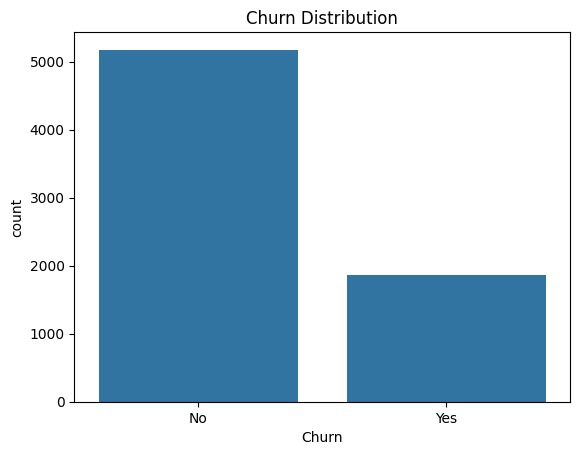

In [19]:
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

Signifies a class imbalance- stratified sampling will be needed for training and testing. 

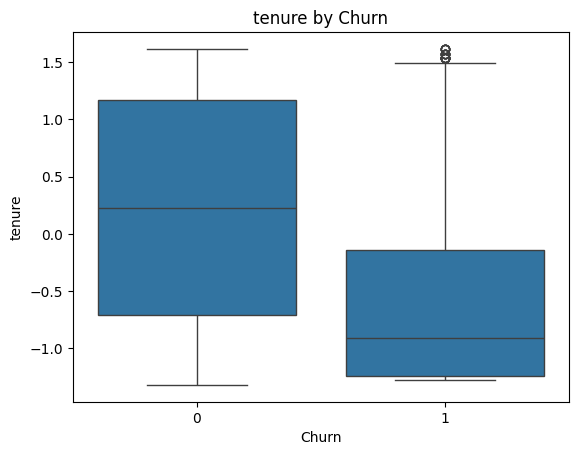

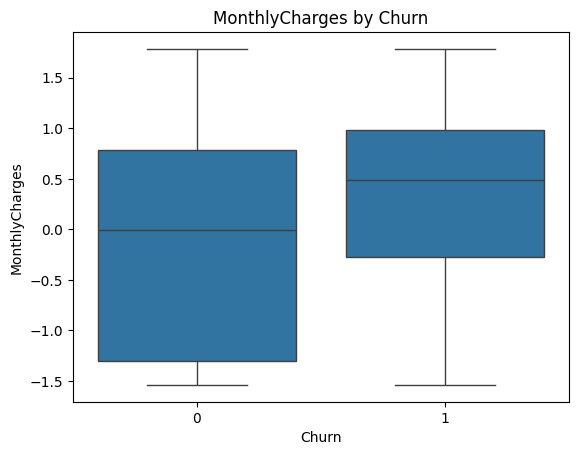

In [20]:
numeric_features = ['tenure', 'MonthlyCharges']

for col in numeric_features:
    sns.boxplot(x='Churn', y=col, data=df_encoded)
    plt.title(f'{col} by Churn')
    plt.show()


Generally speaking- those with longer tenure and less expensive monthly charges are less associated with churn

Tenure is strongly associated with Churn
- Customers who churn tend to leave early
- Suggests a churn prevention opportunity early in the customer lifecycle
- You could target new customers with offers, engagement campaigns, or better onboarding

Higher-paying customers are more likely to churn
This may seem counterintuitive, but makes sense if:
- They're paying for premium services they don’t fully use
- They experience bill shock or poor perceived value

Tackle using usage-based pricing or custom plans to retain them.

## Bivariate analysis

C:\Users\hanam\AppData\Local\Temp\ipykernel_20292\3348735191.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_sorted.values, y=corr_sorted.index, palette=colors)


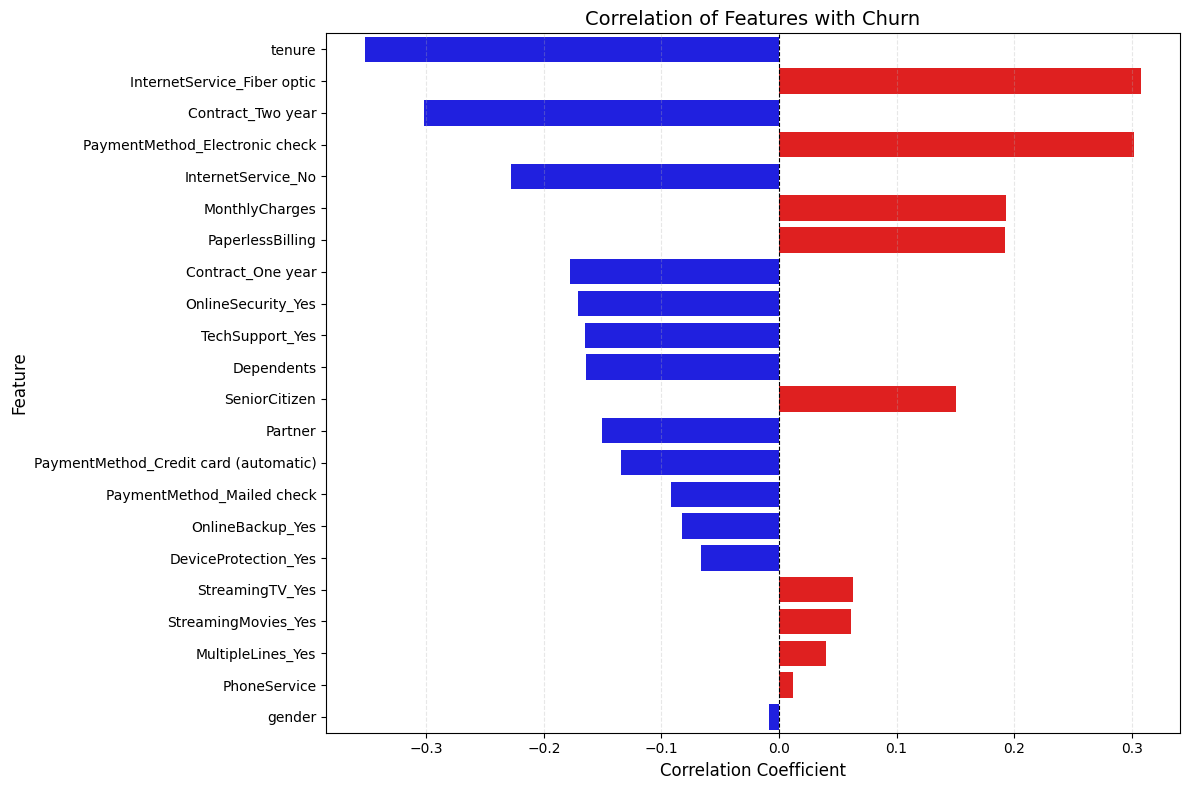

In [21]:
# Calculate correlations with Churn (excluding Churn itself)
corr = df_encoded.corr(numeric_only=True)['Churn'].drop('Churn')

# Sort by absolute correlation strength
corr_sorted = corr.reindex(corr.abs().sort_values(ascending=False).index)

# Create color list: red = positive, blue = negative correlation
colors = ['red' if val > 0 else 'blue' for val in corr_sorted]

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x=corr_sorted.values, y=corr_sorted.index, palette=colors)

# Aesthetics
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Correlation of Features with Churn', fontsize=14)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


Features Positively Correlated with Churn (Increase Risk)
1. InternetService_Fiber optic (+0.31)
Customers using fiber optic internet are significantly more likely to churn than those using DSL or no service. This may suggest dissatisfaction with the service quality, speed-to-price ratio, or technical issues specific to fiber users.

2. PaymentMethod_Electronic check (+0.30)
Customers who pay by electronic check show a higher likelihood of churn compared to those using automatic payments or mailed checks. This could signal lower commitment or less engagement with the service.

3. MonthlyCharges (+0.19)
Higher monthly charges are associated with greater churn. Customers facing high bills may feel they’re not getting value for money, or may be more sensitive to pricing changes.

4. PaperlessBilling (+0.17)
Customers enrolled in paperless billing are slightly more likely to churn. This might reflect tech-savvy users who more actively explore competitors or promotions.

5. SeniorCitizen (+0.15)
Being a senior citizen is modestly associated with higher churn. This may reflect different service needs, preferences, or discomfort with newer digital service models.


Features Negatively Correlated with Churn (Reduce Risk)
6. tenure (–0.35)
Tenure is the strongest negative predictor — the longer a customer has stayed, the less likely they are to churn. This reflects loyalty or satisfaction and highlights the value of customer retention efforts early on.

7. Contract_Two year (–0.30)
Customers on two-year contracts are far less likely to churn. This contractual lock-in reflects both a structural constraint and a possible satisfaction commitment.

8. Contract_One year (–0.18)
Similarly, one-year contracts also significantly reduce churn, although to a lesser extent than two-year contracts. This supports the value of offering medium-term commitment plans.

9. OnlineSecurity_Yes (–0.18)
Customers subscribed to online security services churn less, indicating that bundling or offering additional protection services increases perceived value and stickiness.

10. TechSupport_Yes (–0.17)
Having access to tech support also reduces churn likelihood. This highlights how providing reliable help services improves customer satisfaction and retention.

Summary
The strongest drivers of churn are fiber optic internet, electronic check payments, and high monthly charges.

Conversely, long tenure, contractual commitments, and value-added services like security and tech support significantly lower churn risk.

These insights can directly inform churn mitigation strategies such as pricing reviews, payment incentives, and loyalty programs.

## Group analysis

<Axes: xlabel='Contract'>

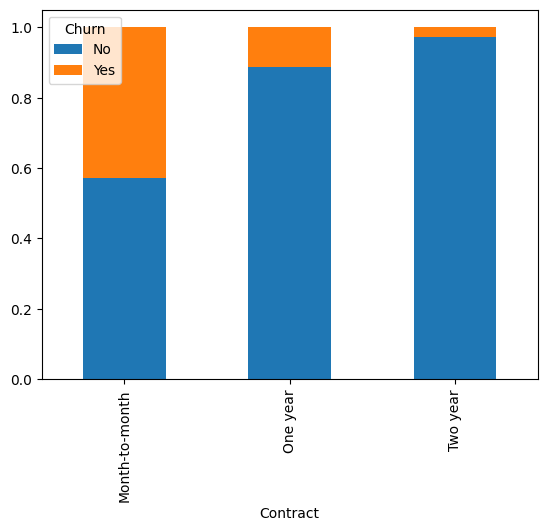

In [22]:
df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)

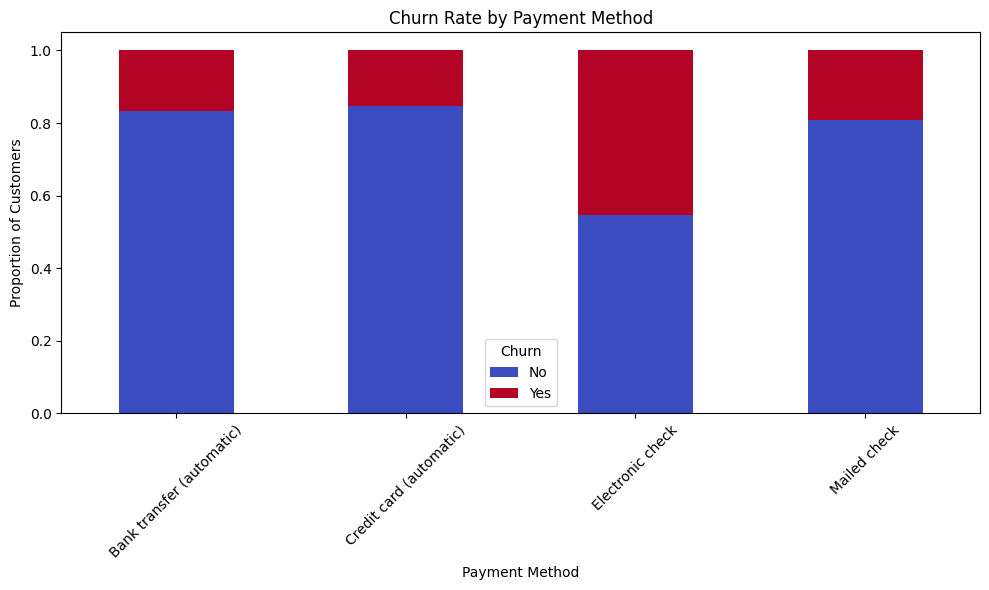

In [23]:
# Normalize to get proportions (churn rate within each payment method)
payment_churn = df.groupby('PaymentMethod')['Churn'].value_counts(normalize=True).unstack()

# Plot
payment_churn.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10, 6))

plt.title('Churn Rate by Payment Method')
plt.ylabel('Proportion of Customers')
plt.xlabel('Payment Method')
plt.xticks(rotation=45)
plt.legend(title='Churn')
plt.tight_layout()
plt.show()

## Multivariate analysis

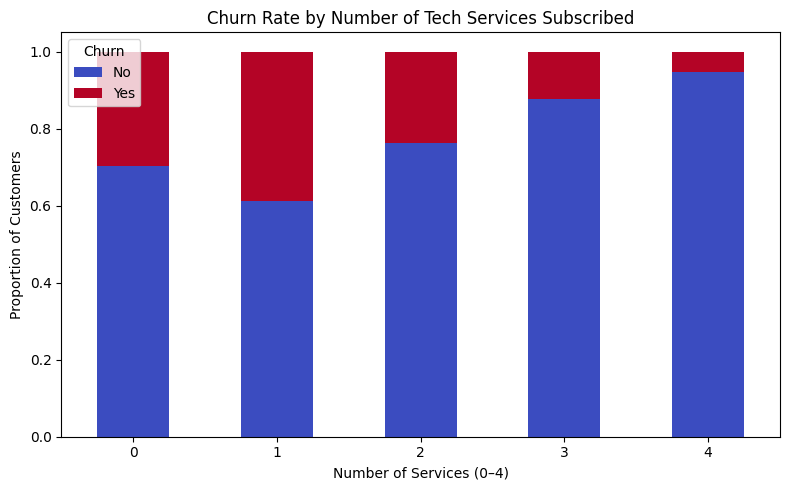

In [24]:
# Map tech columns to binary: 1 if 'Yes', 0 otherwise
tech_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
df['TechServiceCount'] = df[tech_cols].apply(lambda row: sum(row == 'Yes'), axis=1)

# Churn rate by number of tech services
tech_churn = df.groupby('TechServiceCount')['Churn'].value_counts(normalize=True).unstack()

# Plot
tech_churn.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(8, 5))
plt.title('Churn Rate by Number of Tech Services Subscribed')
plt.xlabel('Number of Services (0–4)')
plt.ylabel('Proportion of Customers')
plt.xticks(rotation=0)
plt.legend(title='Churn')
plt.tight_layout()
plt.show()


## Domain specific analysis

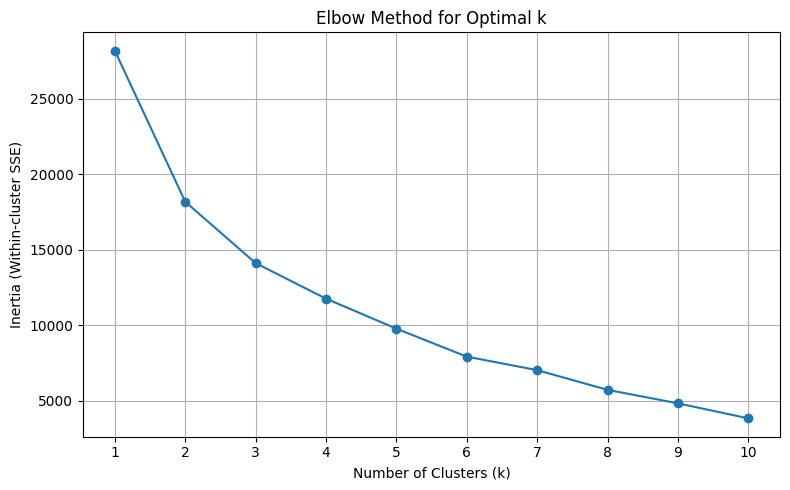

In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Normalize the same features
features = ['OnlineBackup_Yes', 'OnlineSecurity_Yes', 
            'TechSupport_Yes', 'DeviceProtection_Yes']
X = df_encoded[features]
X_scaled = StandardScaler().fit_transform(X)

# Step 2: Calculate inertia (within-cluster sum of squares) for different k
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Step 3: Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xticks(k_range)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster SSE)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df_encoded['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = df_encoded.groupby('Cluster')[features + ['Churn']].mean()
display(cluster_summary)

,OnlineBackup_Yes,OnlineSecurity_Yes,TechSupport_Yes,DeviceProtection_Yes,Churn
Cluster,,,,,
0,0.623762,1.000000,0.641764,1.0,0.101710
1,0.123492,0.080755,0.063450,0.0,0.313057
2,0.476735,0.000000,0.378337,1.0,0.329519
3,0.793061,0.743494,0.734820,0.0,0.161090


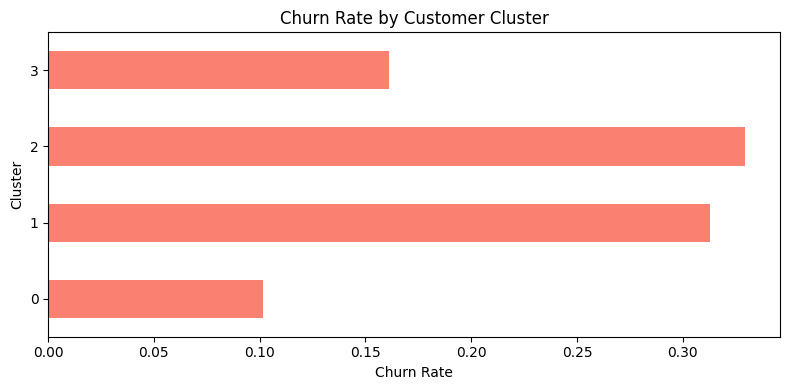

In [27]:
cluster_summary['Churn'].plot(kind='barh', color='salmon', figsize=(8, 4))
plt.title('Churn Rate by Customer Cluster')
plt.xlabel('Churn Rate')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

| Cluster | Churn Risk  | Behavior           | Action                       |
| ------- | ----------- | ------------------ | ---------------------------- |
| 0       | 🔵 Low      | Full tech coverage | Retain & reward              |
| 1       | 🔴 High     | No services        | Educate & re-engage          |
| 2       | 🔴 Highest  | Partial services   | Upsell security              |
| 3       | 🟠 Moderate | Tech-savvy         | Cross-sell Device Protection |
